**Exercise predictive modeling:**<br>
In this exercise, you recapitulate the principles of predictive modeling. You will build a predictive model for a travel 
insurance, which predicts whether a given insurance offer leads to a claim. 

In the next cells, we provide the code for importing required packages and for loading the data set (You need to adapt the
path to the data.). Afterwards, the exercises begin.  

In [1]:
#Install the packages from the requirement.txt file:
!pip install -r requirements.txt

In [1]:
# required packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.inspection import plot_partial_dependence

import os
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

In [2]:
## read data
path='travel insurance.csv'
trav_ins = pd.read_csv(path,
                       index_col=False,
                       sep=',', encoding='utf-8')

In [3]:
## get to know the data
print('Shape of data: ',trav_ins.shape,'\n')
print('Head of data: \n',trav_ins.head(10),'\n')
print('Descriptive statistics of data: \n')
print('Numerical columns: \n',trav_ins.describe(include=np.number),'\n')
print('Categorical columns: \n',trav_ins.describe(include=object),'\n')

Shape of data:  (63326, 11) 

Head of data: 
   Agency    Agency Type Distribution Channel                     Product Name  \
0    CBH  Travel Agency              Offline               Comprehensive Plan   
1    CBH  Travel Agency              Offline               Comprehensive Plan   
2    CWT  Travel Agency               Online  Rental Vehicle Excess Insurance   
3    CWT  Travel Agency               Online  Rental Vehicle Excess Insurance   
4    CWT  Travel Agency               Online  Rental Vehicle Excess Insurance   
5    JZI       Airlines               Online                       Value Plan   
6    CWT  Travel Agency               Online  Rental Vehicle Excess Insurance   
7    CWT  Travel Agency               Online  Rental Vehicle Excess Insurance   
8    CWT  Travel Agency               Online  Rental Vehicle Excess Insurance   
9    CWT  Travel Agency               Online  Rental Vehicle Excess Insurance   

  Claim  Duration    Destination  Net Sales  Commision (in val

In [4]:
#Remove the rows where the feature Duration has negative values:
trav_ins=trav_ins[trav_ins['Duration']>=0]
#Get the number of duplicated rows and remove any duplicates after that:
print('Number of duplicated samples: ',trav_ins[trav_ins.duplicated()].shape[0])
trav_ins=trav_ins.drop_duplicates(keep='first')

Number of duplicated samples:  8042


**Exercise 1:**<br>
Impute missing values with an approach of your own choice.

Overview missing values per feature: 
 Agency                      0
Agency Type                 0
Distribution Channel        0
Product Name                0
Claim                       0
Duration                    0
Destination                 0
Net Sales                   0
Commision (in value)        0
Gender                  38321
Age                         0
dtype: int64


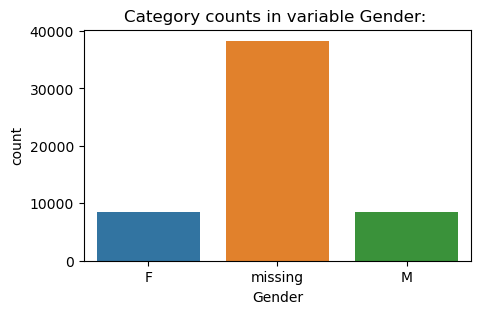

In [5]:
print('Overview missing values per feature: \n',trav_ins.isna().sum())
trav_ins['Gender']=trav_ins['Gender'].fillna('missing')
plt.rcParams['figure.figsize']=5,3
sns.countplot(x='Gender',data=trav_ins)
plt.title('Category counts in variable Gender: ')
plt.show()
plt.close()

**Exercise 2:**<br>
Appropriately encode the target "Claim".

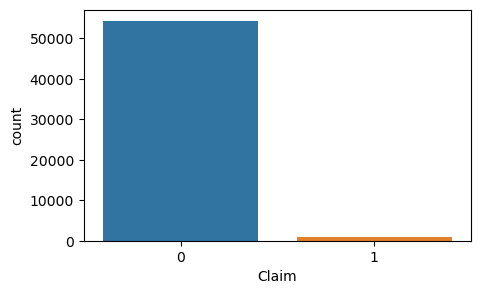

In [6]:
trav_ins['Claim']=trav_ins['Claim'].map({'No':0,'Yes':1})
plt.rcParams['figure.figsize']=5,3
sns.countplot(x='Claim',data=trav_ins)
plt.show()
plt.close()

**Exercise 3:**<br>
Appropriately encode the categorical variables. We recommend merging categories with few observations in one group.

In [7]:
def group_categorical_levels(grouping_criteria,data):
    categorical_columns=data.select_dtypes(include=object).columns

    for cat_col in categorical_columns:
        category_counts=data[cat_col].value_counts()
        print('Categorical column: ',cat_col)
        print('Category counts before grouping: \n',category_counts,'\n')
        data[cat_col]=np.where(data[cat_col].isin(category_counts[category_counts.lt(grouping_criteria)].index),'Other',data[cat_col])
        if len(data[cat_col].value_counts().keys())!=len(category_counts.keys()):
            print('Category counts after grouping: \n',data[cat_col].value_counts(),'\n\n')
    return data

In [8]:
trav_ins=group_categorical_levels(grouping_criteria=2000,
                         data=trav_ins.copy())
trav_ins=pd.get_dummies(data=trav_ins,
                        prefix_sep='_',columns=trav_ins.select_dtypes(include=object).columns)



Categorical column:  Agency
Category counts before grouping: 
 EPX    28956
CWT     8082
C2B     7782
JZI     6038
SSI      950
LWC      684
RAB      646
TST      500
JWT      440
KML      335
ART      325
CCR      178
CBH      101
TTW       94
CSR       86
ADM       82
Name: Agency, dtype: int64 

Category counts after grouping: 
 EPX      28956
CWT       8082
C2B       7782
JZI       6038
Other     4421
Name: Agency, dtype: int64 


Categorical column:  Agency Type
Category counts before grouping: 
 Travel Agency    39098
Airlines         16181
Name: Agency Type, dtype: int64 

Categorical column:  Distribution Channel
Category counts before grouping: 
 Online     54227
Offline     1052
Name: Distribution Channel, dtype: int64 

Categorical column:  Product Name
Category counts before grouping: 
 Cancellation Plan                       15308
2 way Comprehensive Plan                11136
Rental Vehicle Excess Insurance          8082
Basic Plan                               5182
Bronze

**Exercise 4:**<br>
Split 80% of the data in the training set and the remaining 20% data in the test set.

In [9]:
X_train, X_test, y_train, y_test=train_test_split(trav_ins.drop(['Claim'],axis=1),#features
                                                                  trav_ins['Claim'],#target
                                                                  test_size=0.2,random_state=5)

**Exercise 5:**<br>
Build a random forest model on the training data. Find the best tuning parameters by grid search.  
Below is a simple grid, which you could choose.

In [10]:
## Define a hyperparameter grid for tuning the ML model:
param_grid = {'n_estimators': [500,1000],
              'max_features': [4, 8, 12],
              'max_depth':[10,15]
              }

In [11]:
#Perform Grid Search Cross Validation with 5 folds:
gs_rf=GridSearchCV(estimator=RandomForestClassifier(),
                   param_grid=param_grid,
                   cv=5,scoring='roc_auc',
                   verbose=1)
gs_rf.fit(X_train,y_train)

print('Grid Search CV Results when grouping categorical levels with less than 2000 occurances: \n')
print('Best Score: ',gs_rf.best_score_)
print('Best parameters: ',gs_rf.best_params_)
rf_best=gs_rf.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Grid Search CV Results when grouping categorical levels with less than 2000 occurances: 

Best Score:  0.8091130575980096
Best parameters:  {'max_depth': 10, 'max_features': 8, 'n_estimators': 1000}


**Exercise 6:**<br>
Evaluate the model by appropriate metrics on the test set. Is the model able to predict claims with certainty?
Is the model usefull for application?

In [12]:
from sklearn.metrics import recall_score, precision_score,roc_auc_score
predicted_labels=rf_best.predict(X_test)
predicted_probas=rf_best.predict_proba(X_test)
predicted_probas=predicted_probas[:,1]
print('Results on test dataset: \n')
print('Recall Score: ',round(recall_score(y_true=y_test,y_pred=predicted_labels),3))
print('Precision Score: ',round(precision_score(y_true=y_test,y_pred=predicted_labels),3))
print('AUC Score: ',round(roc_auc_score(y_true=y_test,y_score=predicted_probas),3))

Results on test dataset: 

Recall Score:  0.0
Precision Score:  0.0
AUC Score:  0.803


C:\Users\Georg Velev\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
adjusted_labels=np.where(predicted_probas>=predicted_probas.mean(),1.0,0.0)
print('Prediction counts: ',np.unique(adjusted_labels,return_counts=True))
print('Recall Score: ',round(recall_score(y_true=y_test,y_pred=adjusted_labels),3))
print('Precision Score: ',round(precision_score(y_true=y_test,y_pred=adjusted_labels),3))


Prediction counts:  (array([0., 1.]), array([8716, 2340], dtype=int64))
Recall Score:  0.652
Precision Score:  0.056


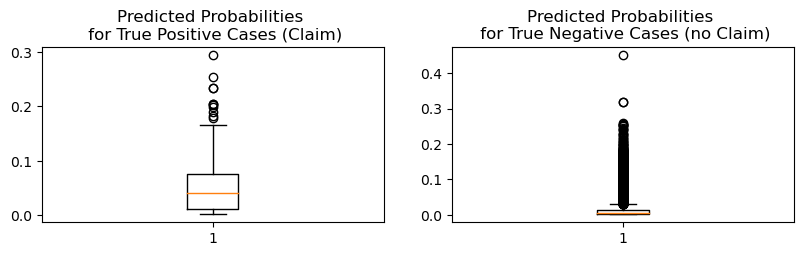

In [14]:
plt.rcParams['figure.figsize']=15,5
ax1=plt.subplot(2,3,1)
ax2=plt.subplot(2,3,2)

#First Boxplot:
true_positives_indices=np.where(y_test==1.0)[0]
predicted_proba_TP=predicted_probas[true_positives_indices]
ax1.boxplot(predicted_proba_TP)
ax1.set_title('Predicted Probabilities \n for True Positive Cases (Claim)')

#Second Boxplot:
true_negative_indices=np.where(y_test==0)[0]
predicted_proba_TN=predicted_probas[true_negative_indices]
ax2.boxplot(predicted_proba_TN)
ax2.set_title('Predicted Probabilities \n for True Negative Cases (no Claim)')
plt.show()
plt.close()

**Bonus:**<br>
Identify which features are most relevant in predicting claims and how they affect the predictions.

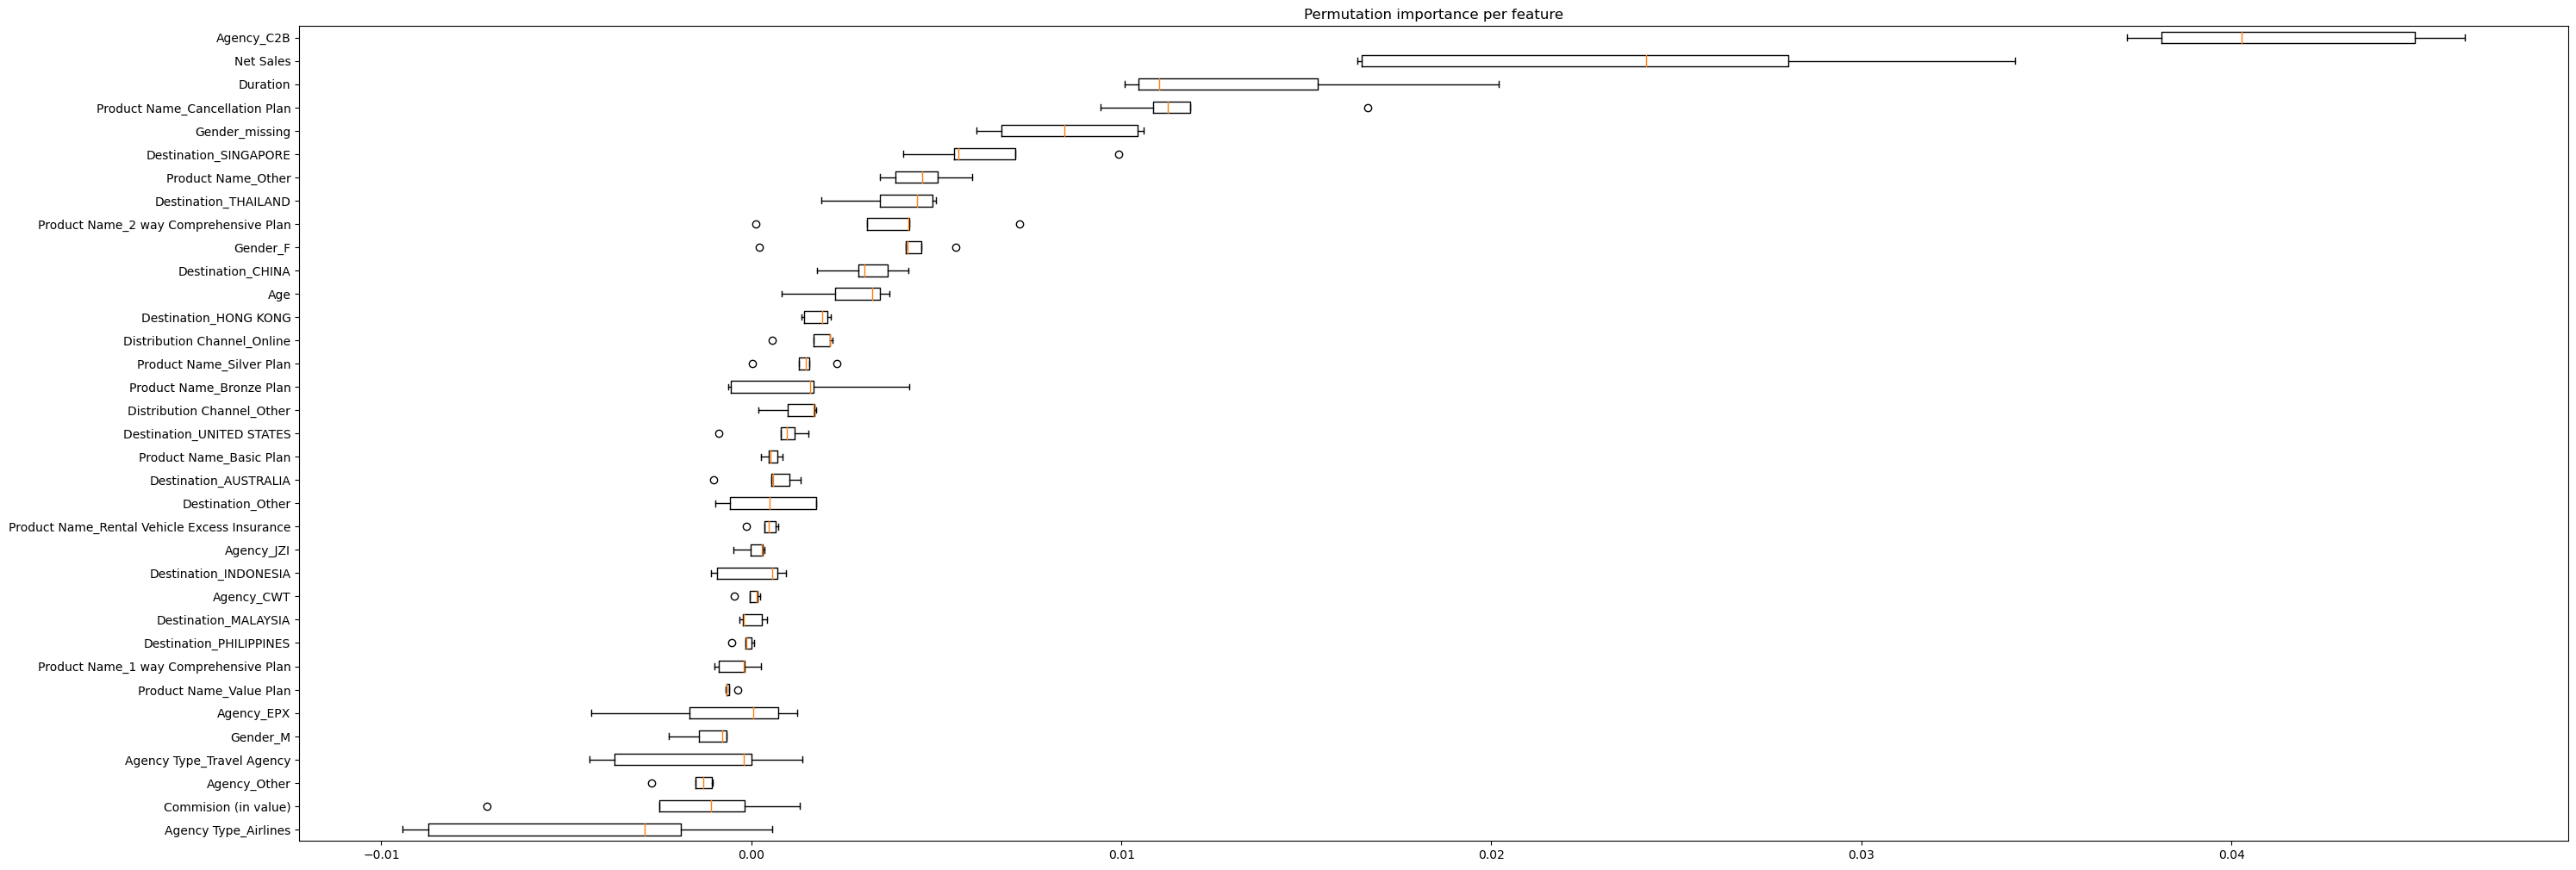

In [152]:
## feature importance
perm_imp=permutation_importance(estimator=rf_best,
                                X=X_test,
                                y=y_test,
                                scoring='roc_auc',random_state=123)

sorted_idx_features=perm_imp.importances_mean.argsort()

plt.rcParams['figure.figsize']=30,10
fig,ax=plt.subplots()
ax.boxplot(perm_imp.importances[sorted_idx_features].T,
          vert=False, 
          labels=X_test.columns[sorted_idx_features])
fig.tight_layout()
plt.title('Permutation importance per feature')
plt.show()
plt.close()

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


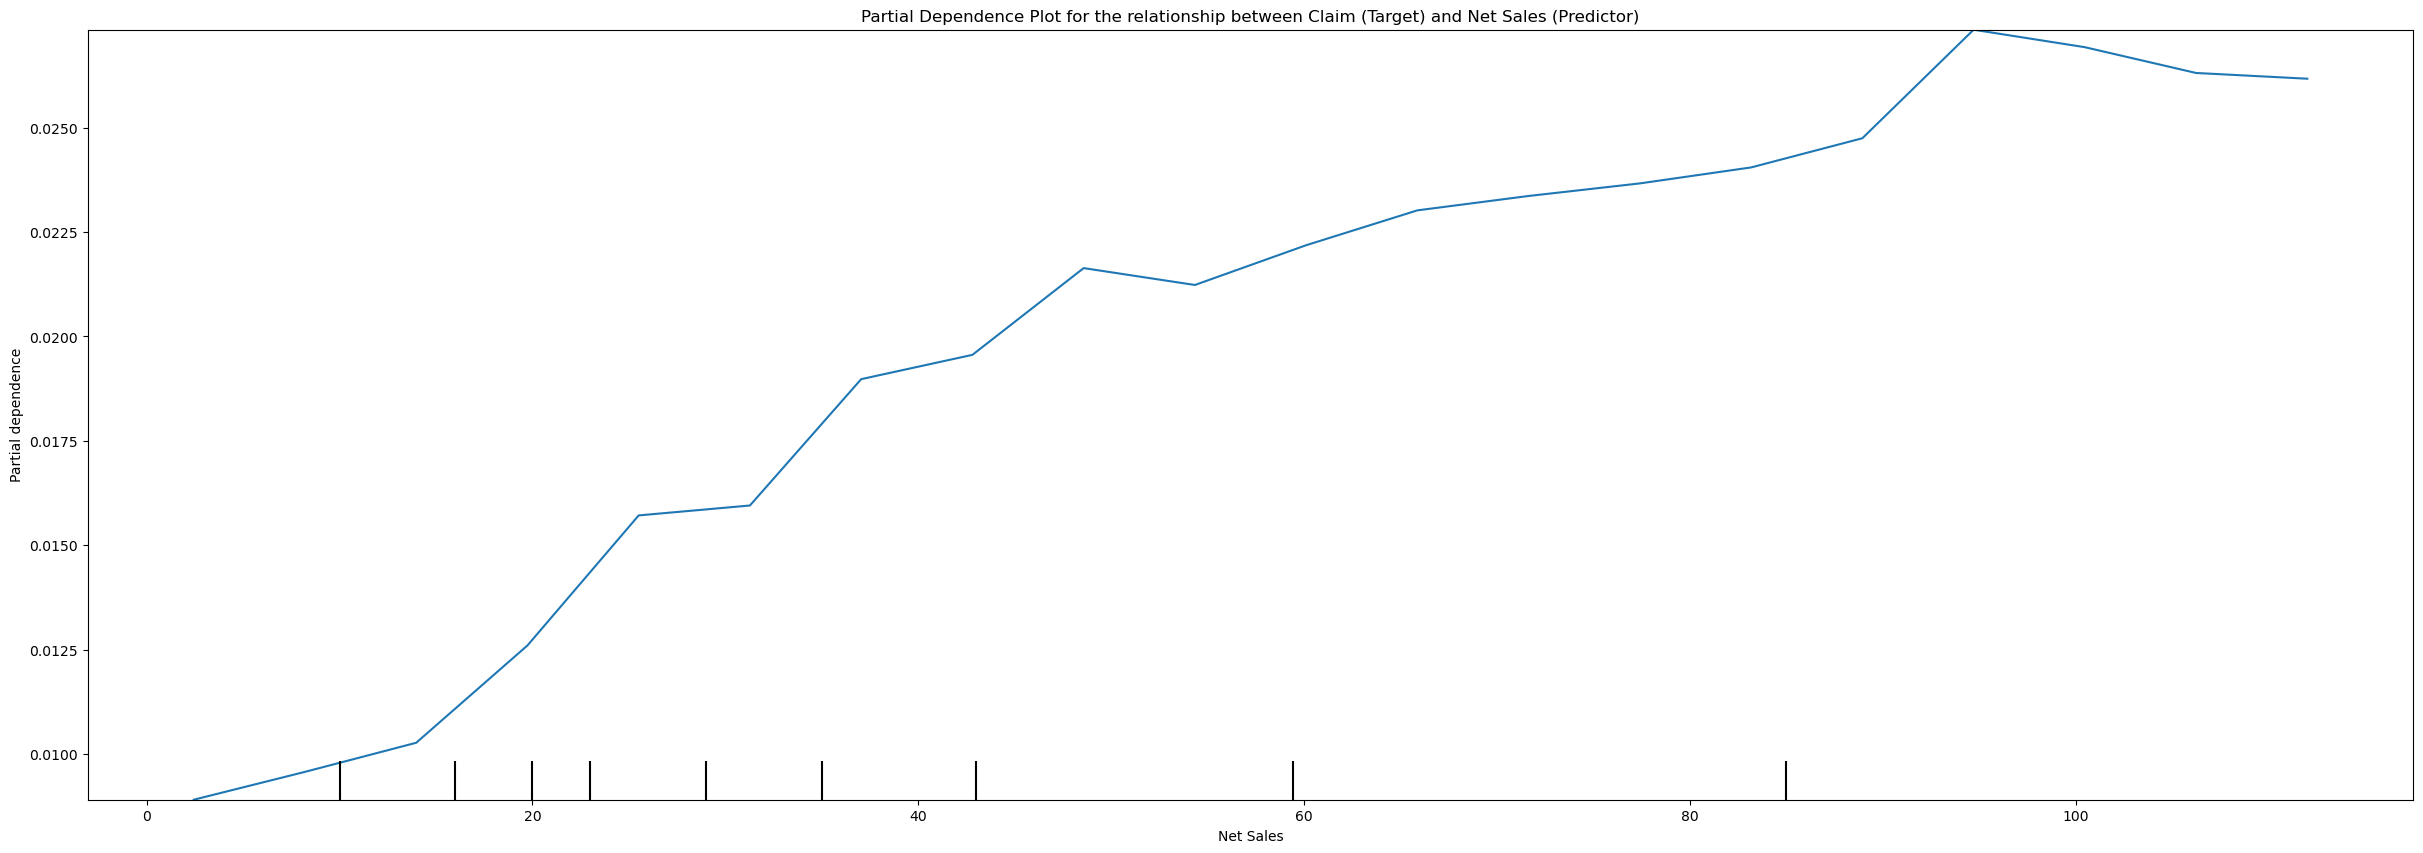

In [153]:
## partial dependence plot
plt.rcParams['figure.figsize']=30,10
plot_partial_dependence(estimator=rf_best, 
                        X=X_test, 
                        features=['Net Sales'], 
                        #n_jobs=3, 
                        grid_resolution=20)
plt.title('Partial Dependence Plot for the relationship between Claim (Target) and Net Sales (Predictor)')
plt.show()
plt.close()

Tune the grouping condition for the reduction of the number of categorical levels (as requested during the tutorial session)

In [15]:
trav_ins = pd.read_csv(path,index_col=False,sep=',', encoding='utf-8')
trav_ins=trav_ins[trav_ins['Duration']>=0]
trav_ins=trav_ins.drop_duplicates(keep='first')
trav_ins['Gender']=trav_ins['Gender'].fillna('missing')
trav_ins['Claim']=trav_ins['Claim'].map({'No':0,'Yes':1})

#Pick several values to be used for the grouping of the categorical levels: 
grouping_condition_list=[500,2000]

#Build the loop in which you preprocess categorical features from your data, 
#split into train and test set, 
#and get cross validation results:
for gr_ct in grouping_condition_list:
    #Group the levels:
    
    print('\033[1m','Grouping condition:','\033[0m',' less than ',gr_ct,'occurances')
    trav_ins_grouped=group_categorical_levels(grouping_criteria=gr_ct,
                         data=trav_ins.copy())
    
    #Get dummy indicator variables:
    trav_ins_grouped=pd.get_dummies(data=trav_ins_grouped,
                        prefix_sep='_',columns=trav_ins_grouped.select_dtypes(include=object).columns)
    print('Shape of dataset after grouping of categorical levels and creating dummy indicator variables: ',trav_ins_grouped.shape)
    
    X_train, X_test, y_train, y_test=train_test_split(trav_ins_grouped.drop(['Claim'],axis=1),#features
                                                      trav_ins_grouped['Claim'],#target
                                                      test_size=0.2,random_state=5)
    
    #Perform Grid Search Cross Validation with 5 folds:
    gs_rf=GridSearchCV(estimator=RandomForestClassifier(),
                       param_grid=param_grid,
                       cv=5,scoring='roc_auc',verbose=1)
    gs_rf.fit(X_train,y_train)

    print('Grid Search CV Results when grouping categorical levels with less than',gr_ct,' occurances: \n')
    print('Best Score: ',gs_rf.best_score_)
    print('Best parameters: ',gs_rf.best_params_,'\n')



 Grouping condition:   less than  500 occurances
Categorical column:  Agency
Category counts before grouping: 
 EPX    28956
CWT     8082
C2B     7782
JZI     6038
SSI      950
LWC      684
RAB      646
TST      500
JWT      440
KML      335
ART      325
CCR      178
CBH      101
TTW       94
CSR       86
ADM       82
Name: Agency, dtype: int64 

Category counts after grouping: 
 EPX      28956
CWT       8082
C2B       7782
JZI       6038
Other     1641
SSI        950
LWC        684
RAB        646
TST        500
Name: Agency, dtype: int64 


Categorical column:  Agency Type
Category counts before grouping: 
 Travel Agency    39098
Airlines         16181
Name: Agency Type, dtype: int64 

Categorical column:  Distribution Channel
Category counts before grouping: 
 Online     54227
Offline     1052
Name: Distribution Channel, dtype: int64 

Categorical column:  Product Name
Category counts before grouping: 
 Cancellation Plan                       15308
2 way Comprehensive Plan           

Different ways of encoding categorical features for ML models: https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02